In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [51]:
# # No need to run this if you have already downloaded it previously
# !python -m spacy download en_core_web_lg 

In [52]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [53]:
df = pd.read_csv('mkbhd.csv')

all_captions = df['Captions'].values

In [54]:
from sentence_transformers import SentenceTransformer

sentence_encoder_model = SentenceTransformer("all-MiniLM-L6-v2")

/Users/vk/Desktop/ML/data/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [55]:
embeddings = sentence_encoder_model.encode(all_captions, show_progress_bar=True)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [56]:
df['Full Embeddings']= embeddings.tolist()

In [57]:
#do pip 'install umap-learn', and not 'pip install umap'
import umap.umap_ as umap
import hdbscan

# Create embeddings
# 5 dimensional for clustering
# 2 dimensional for visualisation and plotting

umap_embeddings_5dim = umap.UMAP(n_neighbors = 30, min_dist = 0.0, n_components = 30, metric = 'cosine').fit_transform(embeddings)
umap_embeddings_2dim = umap.UMAP(n_neighbors = 30, n_components = 2, metric = 'cosine', min_dist = 0.0).fit_transform(embeddings)

df["umap_embeddings_2dim"]  = umap_embeddings_2dim.tolist()
df.head(3)


,Unnamed: 0,Id,Title,Published At,Captions,View Count,Like Count,Video Duration,CaptionsDuration,WordCount,Words Per Minute,Year,Full Embeddings,umap_embeddings_2dim
0,0,GQkkHtBD1BM,Taking 1000 Steps In Every Smartwatch!,2024-01-19T23:44:36Z,I'm curious how accurate the step counters are...,13451274,515806,61.640,116.961,152,77.974710,2024,"[-0.09249689429998398, -0.05101953074336052, -...","[8.06787395477295, 12.06462287902832]"
1,1,B3szaVzQx0o,Google Pixel 8A Impressions: Just Get The 8!,2024-05-07T16:18:33Z,"(bright music) All right, so there is just o...",2445129,83538,441.624,440.281,1453,198.009907,2024,"[-0.0974966511130333, -0.01660434529185295, 0....","[10.185091972351074, 11.051623344421387]"
2,2,8reaJG7z-is,I Visited Apple&#39;s Secret iPhone Testing Labs!,2024-06-07T21:31:09Z,"♪ Ah, ah, ah, yeah, yeah ♪ ♪ Ah, ah, ah, yeah,...",2904968,124954,650.129,642.563,2172,202.812798,2024,"[-0.06019112467765808, 0.005124949384480715, 0...","[9.357427597045898, 12.37620735168457]"


In [58]:
cluster_scripts = hdbscan.HDBSCAN(min_cluster_size = 15, metric = 'euclidean', cluster_selection_method = 'eom').fit(umap_embeddings_5dim)

print(set(cluster_scripts.labels_))
print(len(set(cluster_scripts.labels_)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
14


In [59]:
from collections import Counter
counter = Counter(cluster_scripts.labels_)
print(counter)

Counter({2: 208, -1: 202, 12: 200, 1: 100, 10: 84, 7: 73, 9: 52, 0: 46, 11: 36, 4: 28, 8: 26, 5: 25, 6: 24, 3: 22})


In [60]:
df["umap_embeddings_5dim"]  = umap_embeddings_5dim.tolist()
df["umap_embeddings_2dim"]  = umap_embeddings_2dim.tolist()
df["Cluster Labels"]  = cluster_scripts.labels_

In [61]:
print(df.shape)
print(len(embeddings))
print(len(umap_embeddings_2dim))

(1126, 16)
1126
1126


In [62]:
import plotly.express as px

col="umap_embeddings_2dim"

hover_data =["Id", "Cluster Labels", "Year", "View Count", "Like Count"]
hover_name = "Title"
plot_values = np.stack(df[col], axis=1)


x, y = plot_values[0], plot_values[1]
fig = px.scatter(
            df,
            x=x,
            y=y,
            color="Cluster Labels",
            hover_data=hover_data,
            title="Visualize Video Scripts",
            hover_name=hover_name,
        )

fig.show()

In [63]:

filteredScripts = []

# Remove stopwords, punctuations and proper nouns so that TFIDF works better to fetch keywords
for caption in all_captions:

      d = nlp(str(caption))
      caption_annotated = [tok.text for tok in d if not
                                  (tok.is_punct or tok.is_stop 
                                    or tok.is_space or tok.pos_ == "PROPN" )
                                  ]
      caption_annotated_string = ' '.join(caption_annotated)                         
      filteredScripts.append(caption_annotated_string)

In [64]:
df['Filtered Scripts'] = filteredScripts
df.head(2)

,Unnamed: 0,Id,Title,Published At,Captions,View Count,Like Count,Video Duration,CaptionsDuration,WordCount,Words Per Minute,Year,Full Embeddings,umap_embeddings_2dim,umap_embeddings_5dim,Cluster Labels,Filtered Scripts
0,0,GQkkHtBD1BM,Taking 1000 Steps In Every Smartwatch!,2024-01-19T23:44:36Z,I'm curious how accurate the step counters are...,13451274,515806,61.640,116.961,152,77.974710,2024,"[-0.09249689429998398, -0.05101953074336052, -...","[8.06787395477295, 12.06462287902832]","[4.035818099975586, 5.40556001663208, 5.409874...",3,curious accurate step counters smart watches o...
1,1,B3szaVzQx0o,Google Pixel 8A Impressions: Just Get The 8!,2024-05-07T16:18:33Z,"(bright music) All right, so there is just o...",2445129,83538,441.624,440.281,1453,198.009907,2024,"[-0.0974966511130333, -0.01660434529185295, 0....","[10.185091972351074, 11.051623344421387]","[3.593104600906372, 4.947223663330078, 5.67012...",8,bright music right thing starting feel little ...


In [65]:
# Group scripts based on cluster
docs_df_videos = pd.DataFrame(df, columns=["Filtered Scripts", "Title", "Like Count", "View Count"])
docs_df_videos['Topic'] = cluster_scripts.labels_
docs_df_videos['Count'] = 1
docs_df_videos = docs_df_videos.groupby(['Topic'], as_index = False).agg({'Filtered Scripts': ' '.join, 'Title': ' '.join, 'Like Count': 'sum', 'Count': 'count', 'View Count': 'sum'})

docs_df_videos['Avg Like Count'] = docs_df_videos['Like Count'] / docs_df_videos['Count']
docs_df_videos['Avg View Count'] = docs_df_videos['View Count'] / docs_df_videos['Count']

docs_df_videos.head(4)

,Topic,Filtered Scripts,Title,Like Count,Count,View Count,Avg Like Count,Avg View Count
0,-1,okay best features good object tracking perman...,Apple Vision Pro Hidden Feature ✈️ #protip WWD...,16539507,202,512390239,81878.747525,2.536585e+06
1,0,seated left driver newest car sick lot crazy f...,Unreal Engine 🤝 Electric Cars The Most Tech I&...,5926118,46,171005986,128828.652174,3.717521e+06
2,1,music crazy interesting things new laptop reas...,Here&#39;s the Thing about the M3 Macbook Air....,7510402,100,238113304,75104.020000,2.381133e+06
3,2,upbeat music AI box sign times thing lot commo...,Rabbit R1: Barely Reviewable Twitter’s Edit Bu...,12776015,208,336940417,61423.149038,1.619906e+06


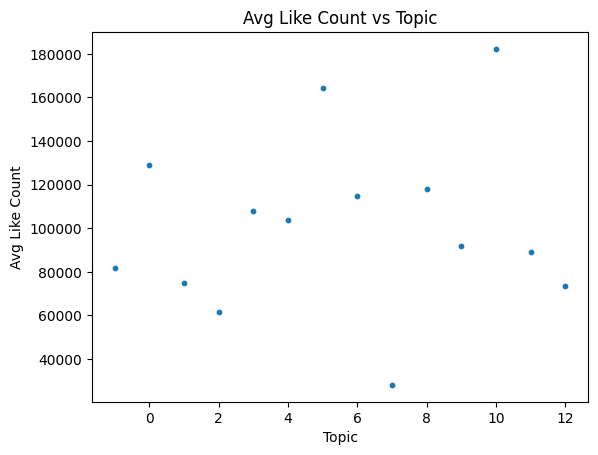

In [66]:
fig, ax = plt.subplots()

x = docs_df_videos['Topic']
y = docs_df_videos['Avg Like Count']

ax.scatter(x, y, s=10)

ax.set_xlabel('Topic')
ax.set_ylabel('Avg Like Count')
ax.set_title('Avg Like Count vs Topic')

plt.show()

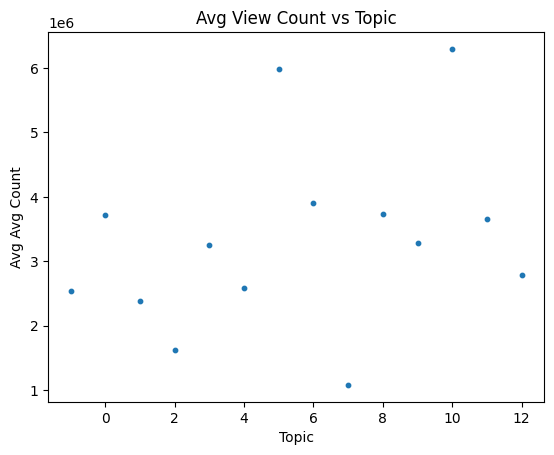

In [67]:
fig, ax = plt.subplots()

x = docs_df_videos['Topic']
y = docs_df_videos['Avg View Count']

ax.scatter(x, y, s=10)

ax.set_xlabel('Topic')
ax.set_ylabel('Avg Avg Count')
ax.set_title('Avg View Count vs Topic')

plt.show()

Text(0.5, 1.0, 'Normalised Avg Counts vs Topic')

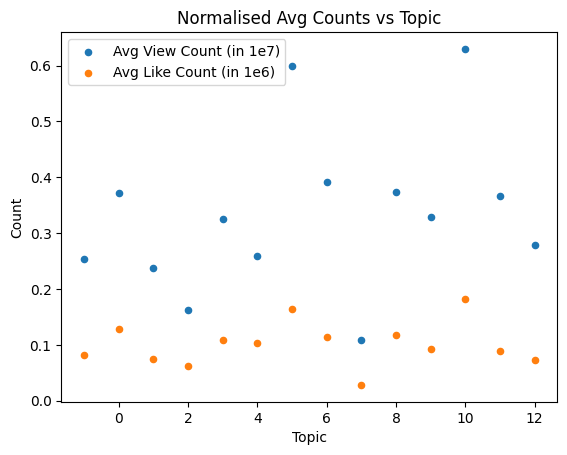

In [68]:
fig, ax = plt.subplots()

x = docs_df_videos['Topic']
y1 = docs_df_videos['Avg View Count']/1e7
y2 = docs_df_videos['Avg Like Count']/1e6

ax.scatter(x, y1, s=20, label = 'Avg View Count (in 1e7)')
ax.scatter(x, y2, s=20, label = 'Avg Like Count (in 1e6)')

ax.set_xlabel('Topic')
ax.set_ylabel('Count')

ax.legend(loc='upper left')
ax.set_title('Normalised Avg Counts vs Topic')


In [69]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [70]:
tf_idf_plots, count_plots = c_tf_idf(docs_df_videos['Filtered Scripts'].values, m=len(docs_df_videos))

In [71]:
top_n_words_plots = extract_top_n_words_per_topic(tf_idf_plots, count_plots, docs_df_videos, n=20)

In [73]:
from pprint import pprint

def get_topic_index_description(top_n_words,ncount):
  topic_indexes = set(top_n_words.keys())
  topic_index_description = {}
  for topic_index in topic_indexes:
    desc = top_n_words[topic_index]
    desc = desc[:ncount]
    desc_string = [x[0] for x in desc]
    desc_string_mod = ", ".join(desc_string)
    topic_index_description[topic_index]  = desc_string_mod
  return topic_index_description

topic_index_description = get_topic_index_description(top_n_words_plots,7)

pprint (topic_index_description)

{-1: 'nitrogen, factual, ions, hangout, fed, garnet, electrolyte',
 0: 'vaporware, median, regenerative, tow, armrest, interiors, regen',
 1: 'weights, easel, haswell, 8th, socket, overclocking, acer',
 2: 'molecules, xlr, teleporting, 100th, zeros, zippers, evf',
 3: 'speakerphone, fingertip, duet, electrocardiogram, flux, sharks, shower',
 4: 'polls, upsets, totals, viruses, semifinals, madness, fakery',
 5: 'lawsuit, postures, lastpass, accordion, assassinations, escobars, '
    'watertight',
 6: 'wasteful, lappable, 2732, demensity, riptide, flipboard, splotching',
 7: 'jailbreaking, peppermint, t4i, nexus5, lime, jailbreak, kindle',
 8: '8a, unblur, 363, chops, bathtub, 449, 4a5',
 9: 'qc25s, coiled, bluebuds, mpow, sweatproof, audiophile, m70x',
 10: '10rs, gizmodo, 11r, ingress, graphene, meteorite, a11',
 11: 'qi2, exclamation, 1plus, clears, hamburger, distinguished, emphasized',
 12: 'ltea, smudges, verdict, ip58, mediocre, metering, 50x'}
